# 1. Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

DATASET_PATH = "C:/Users/Dev/Downloads/dataset/dataset"
species = os.listdir(DATASET_PATH)
len(species)

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

# 2. Data Loading and Preprocessing

In [5]:
# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_test_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Split validation/test
val_size = int(tf.data.experimental.cardinality(val_test_dataset).numpy() * 0.5)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Class names
class_names = train_dataset.class_names

# Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# # Cache/prefetch for performance
# AUTOTUNE = tf.data.AUTOTUNE
# train_dataset = train_dataset.cache().shuffle(200).prefetch(buffer_size=AUTOTUNE)
# val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 77382 files belonging to 100 classes.
Using 54168 files for training.
Found 77382 files belonging to 100 classes.
Using 23214 files for validation.


# 3. Plot some images

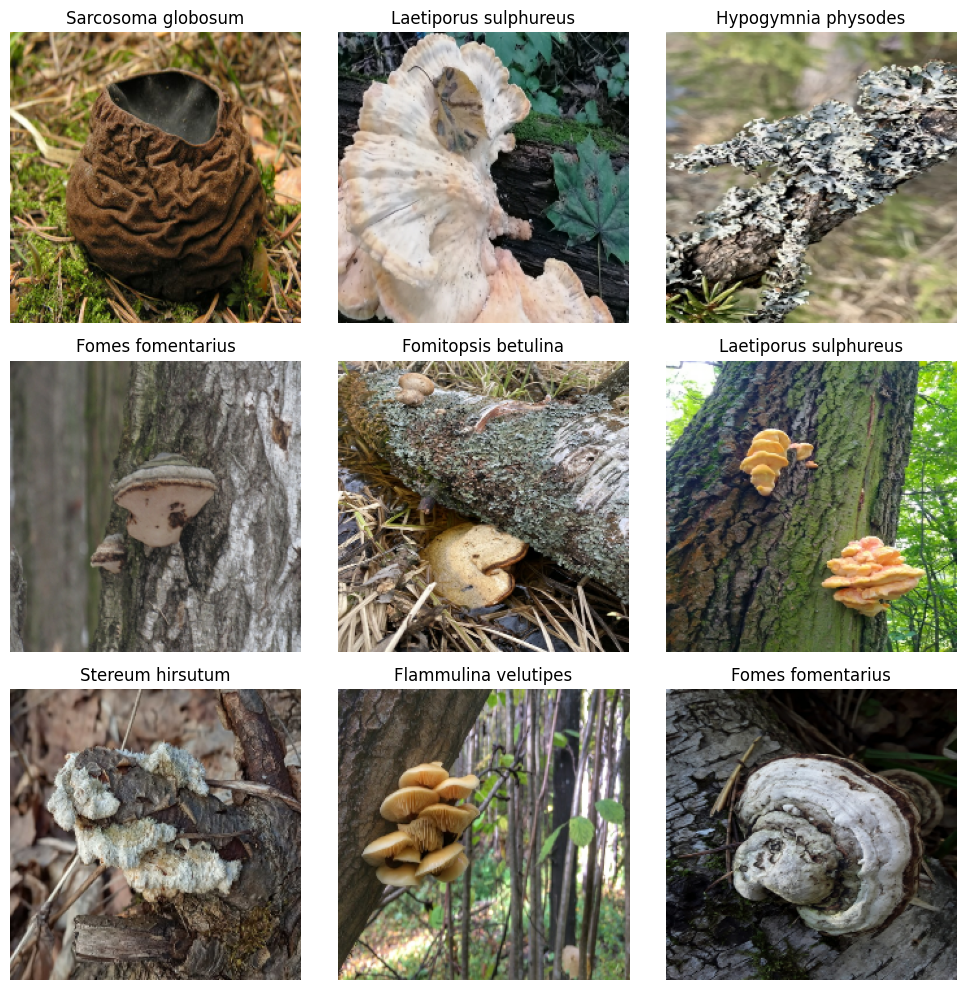

In [6]:
plt.figure(figsize=(10, 10))
for image, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Convert image[i] from float32 to uint8 (0-255 range)
        img = image[i].numpy() * 255.0  # scale back to 0-255
        img = img.astype(np.uint8)      # convert to uint8
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')

plt.show()

# 4. Model Architecture

In [7]:
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
])

# Load MobileNetV2 without the top layer to use as the base model
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze most pre-trained layers
base_model.trainable = True
for layer in base_model.layers[:-15]:  # Freeze all but last 30 layers
    layer.trainable = False

model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.7),
    layers.Dense(len(class_names), activation='softmax')
])

# Define Callbacks

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.5,
    verbose=1,
    min_lr=1e-7
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

# 5. Compile and Train

In [8]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=50,  # Increased max epochs
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
)

Epoch 1/50
264/847 ━━━━━━━━━━━━━━━━━━━━ 3:27 357ms/step - accuracy: 0.0610 - loss: 6.0850

KeyboardInterrupt: 

# 6. Plot training history

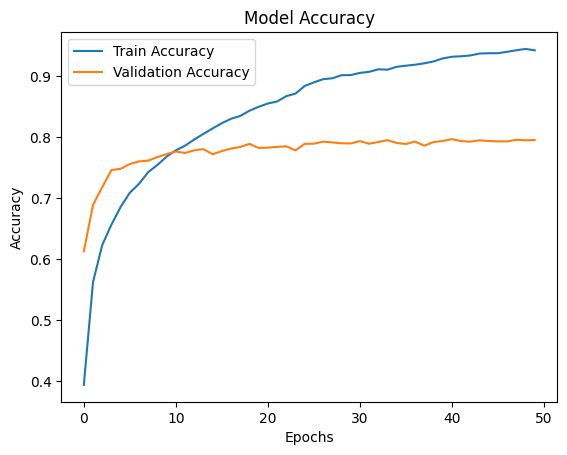

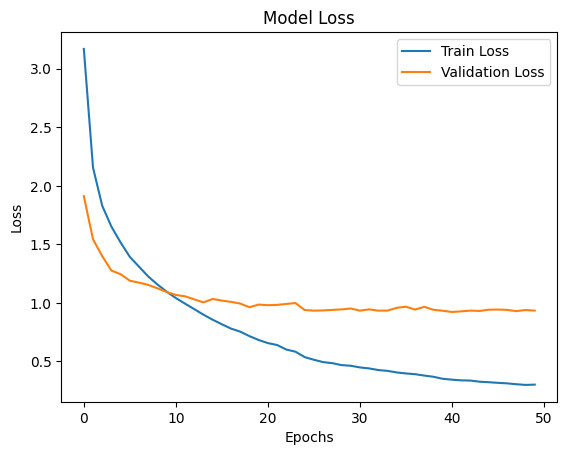

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Evaluating the model

## 7.1 Save/Load Model

In [12]:
model.save("post_test.h5")

In [3]:
# optionally load model
model = tf.keras.models.load_model('C:/Coding/Machine Learning/mushroom-classification/backend/model/post_test.keras')

## 7.2 Test Accuracy

In [6]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

182/182 ━━━━━━━━━━━━━━━━━━━━ 58s 281ms/step - accuracy: 0.8047 - loss: 0.8874
Test Loss: 0.9242
Test Accuracy: 0.7972


## 7.3 Save/Load Training History

In [14]:
import pickle

# Save
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
# Load
with open('training_history.pkl', 'rb') as f:
    history_data = pickle.load(f)

# Now you can plot it again
import matplotlib.pyplot as plt

plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
